In [2]:
!ls

combined-tagging-MC-all.ipynb	   tagging-vertex-MC-loss.ipynb
combined-tagging-MC.ipynb	   test.root
ICL-2017-kaggle-preparation.ipynb  track-tagging-MC.ipynb
MC-channels-check.ipynb		   training.root
old-tagging-MC.ipynb		   vertex-tagging-MC.ipynb
ss_os_training.ipynb		   vertex-tagging-MC-jets.ipynb


In [1]:
%pylab inline
figsize(8, 6)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path.insert(0, "../")

## Import

In [3]:
import pandas
import numpy
from folding_group import FoldingGroupClassifier
from rep.data import LabeledDataStorage
from rep.report import ClassificationReport
from rep.report.metrics import RocAuc
from sklearn.metrics import roc_curve, roc_auc_score

In [4]:
from utils import get_events_number, get_events_statistics

## Reading initial data

In [5]:
import root_numpy
data = pandas.DataFrame(root_numpy.root2array('../datasets/MC/csv/WG/Bu_JPsiK/2012/Tracks.root'))

In [6]:
data.head()

,run,event,Bmass,time,i,mult,partP,partPt,ptB,IPs,...,Dist_phi,N_sig_sw,mu_cut,e_cut,K_cut,MCID,OS_SS,xFlag,K_MCID,BOosc
0,2517778,1110804,5.272273,0.41804,0,12,10.10731,1.275867,3.046546,45.846935,...,0.318931,0,0,0,1,-321,0,0,-1,0
1,2517778,1110804,5.272273,0.41804,1,12,12.52366,0.513155,3.046546,4.899704,...,1.151553,0,0,0,0,211,0,0,-1,0
2,2517778,1110804,5.272273,0.41804,2,12,4.71373,0.597545,3.046546,3.352034,...,0.544899,0,0,0,0,-211,-1,-1,-1,0
3,2517778,1110804,5.272273,0.41804,3,12,4.68713,0.243792,3.046546,102.329247,...,0.395680,0,0,0,0,-211,0,0,-1,0
4,2517778,1110804,5.272273,0.41804,4,12,3.21920,0.612911,3.046546,1.016178,...,0.269237,0,0,0,0,211,-1,-1,-1,0


### Data preprocessing: 

Add necessary features:
- #### define `label` = `signB` * `signTrack`

    * if > 0 (same sign) - label **1**
    * if < 0 (different sign) - label **0**

- #### diff pt, min/max PID

Apply selections:

- **remove ghost tracks**
- **loose slection on PID**

In [9]:
from utils import data_tracks_preprocessing
data = data_tracks_preprocessing(data)

/mnt/mfs/miniconda/envs/rep_py2/lib/python2.7/site-packages/pandas/core/indexing.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/mnt/mfs/miniconda/envs/rep_py2/lib/python2.7/site-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Initial statistics: {'parts': 33632195, 'Events': 1488891}
after  (ghostProb < 0.4)  selection, statistics: {'parts': 32813556, 'Events': 1488885}
after   ( (PIDNNk > 0.0) | (PIDNNm > 0.0) | (PIDNNe > 0.0) | (PIDNNpi > 0.0) | (PIDNNp > 0.0))   selection, statistics: {'parts': 32808324, 'Events': 1488885}


In [11]:
', '.join(data.columns)

'run, event, Bmass, time, i, mult, partP, partPt, ptB, IPs, IP, IPerr, partlcs, EOverP, ghostProb, IPPU, nnkrec, PIDNNk, PIDNNpi, PIDNNp, PIDNNm, PIDNNe, diff_eta, diff_phi, phi, eta, proj, ID, veloch, signB, signTrack, Dist_phi, N_sig_sw, mu_cut, e_cut, K_cut, MCID, OS_SS, xFlag, K_MCID, BOosc, group_column, event_id, diff_pt, cos_diff_phi, max_PID_mu_k, sum_PID_mu_k, max_PID_mu_e, sum_PID_mu_e, max_PID_k_e, sum_PID_k_e, label'

### define all number of events

In [12]:
from utils import compute_N_B_events_MC
N_B_events = compute_N_B_events_MC('../datasets/MC/csv/WG/Bu_JPsiK/2012/Tracks.root',
                                   '../datasets/MC/csv/WG/Bu_JPsiK/2012/Vertices.root')
N_B_events

1488891.0

In [13]:
import json
with open('../models/JPsiKMC.json', 'w') as f:
    json.dump({'N_B_events': N_B_events}, f)

## Tracks sum of charges asymmetry study

#### define regions OS, SS

In [14]:
os_region_mask = (data.IPs > 3) & ((abs(data.diff_eta) > 0.6) | (abs(data.diff_phi) > 0.825))
ss_region_mask = (abs(data.diff_eta) < 0.6) & (abs(data.diff_phi) < 0.825) & (data.IPs < 3)

#### define particles types regions

In [15]:
e_mask = numpy.abs(data.MCID) == 11
mu_mask = numpy.abs(data.MCID) == 13
k_mask = numpy.abs(data.MCID) == 321
pi_mask = numpy.abs(data.MCID) == 211
p_mask = numpy.abs(data.MCID) == 2212

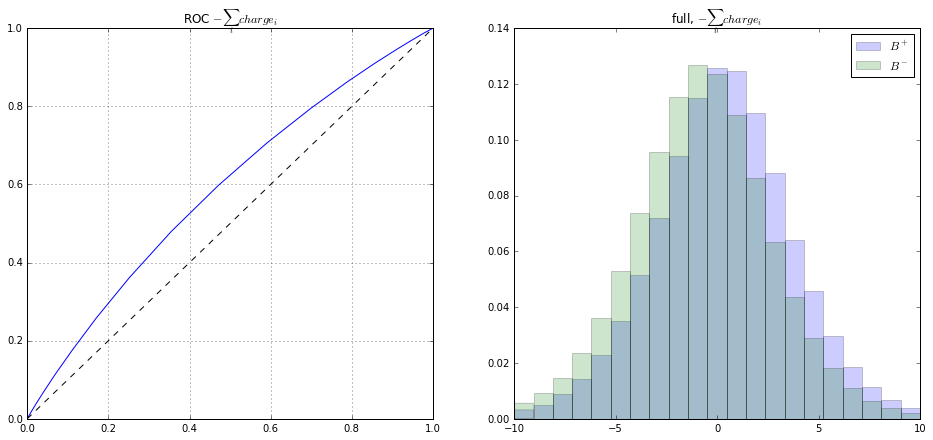

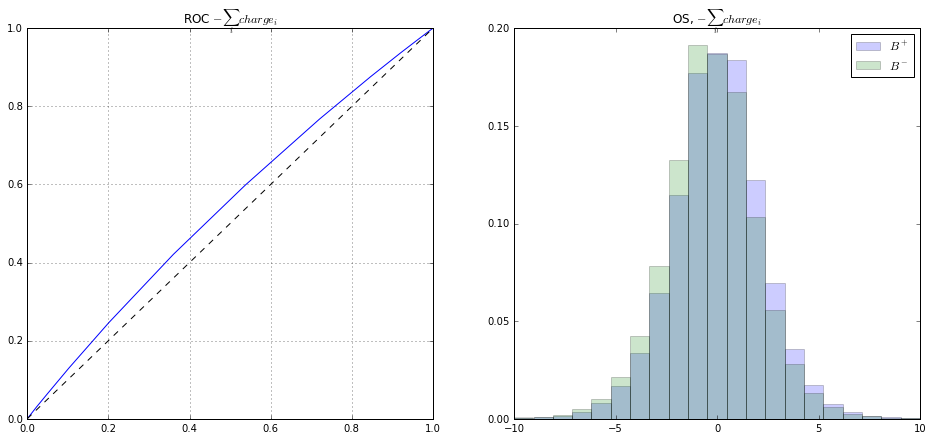

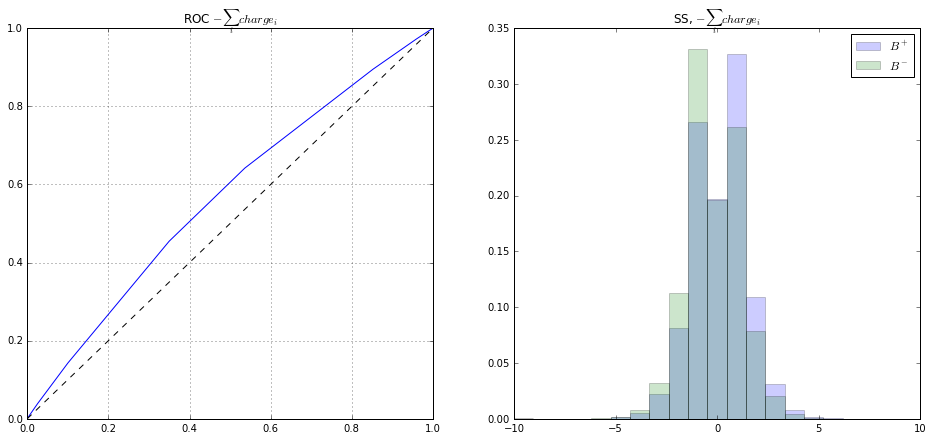

In [16]:
from utils import compute_sum_of_charges
means_sum_of_charges = [compute_sum_of_charges(data[mask], name, bins=21, show_with_signal=False) 
                        for mask, name in zip([data.signB > -100, os_region_mask, ss_region_mask], 
                                              ['full', 'OS', 'SS'])]

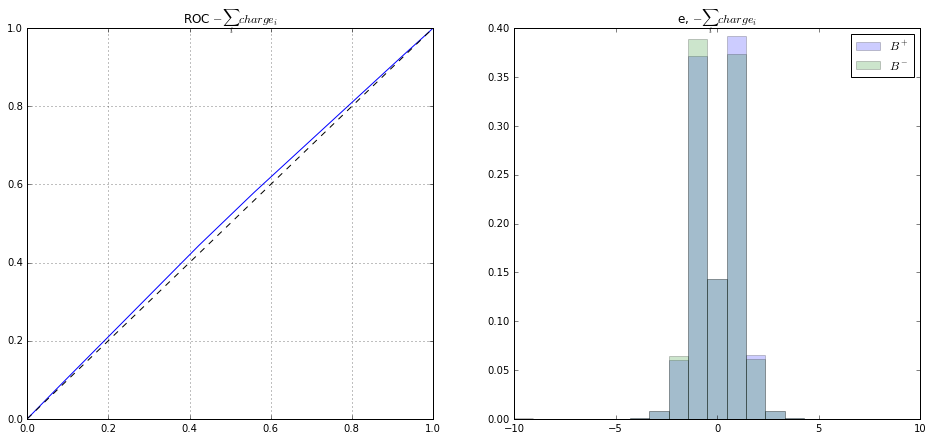

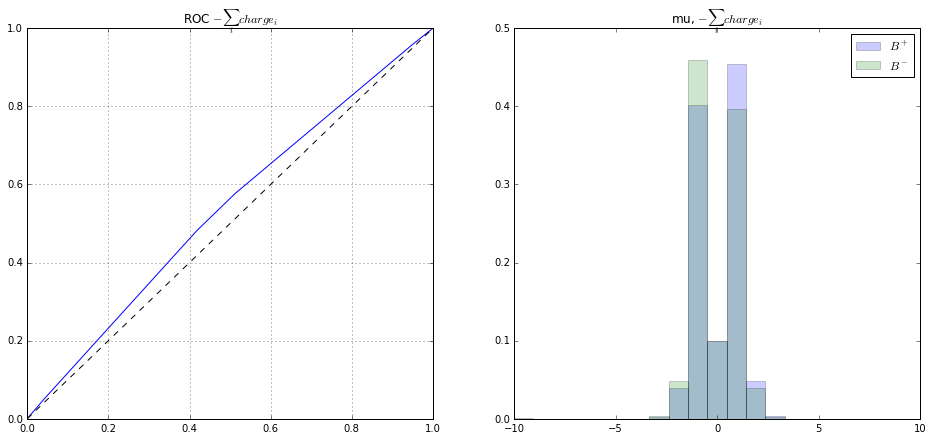

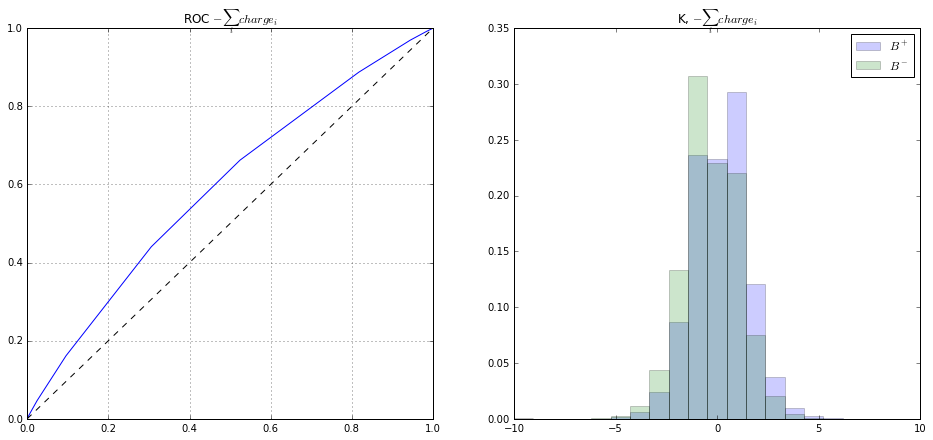

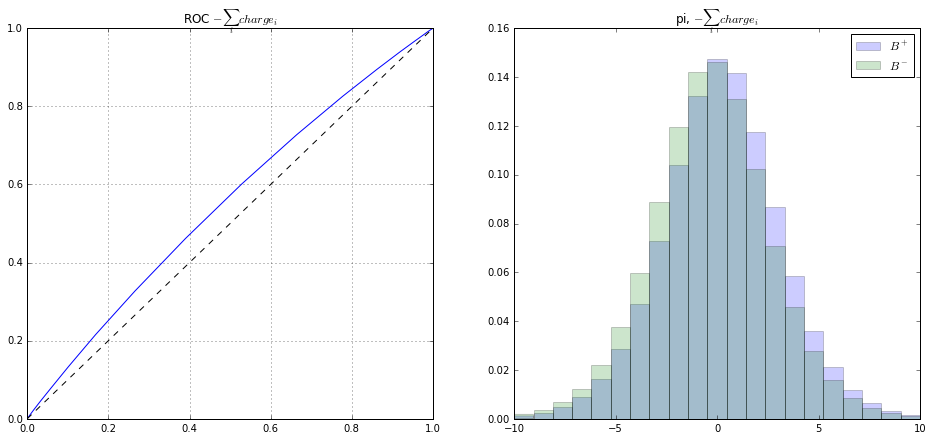

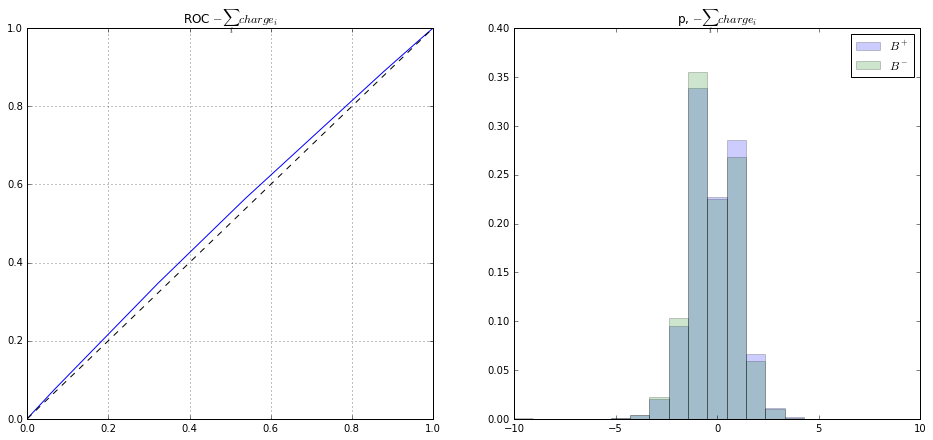

In [17]:
means_sum_of_charges_by_particle = [compute_sum_of_charges(data[mask], name, bins=21, show_with_signal=False) 
                                    for mask, name in zip([e_mask, mu_mask, k_mask, pi_mask, p_mask], 
                                                          ['e', 'mu', 'K', 'pi', 'p'])]

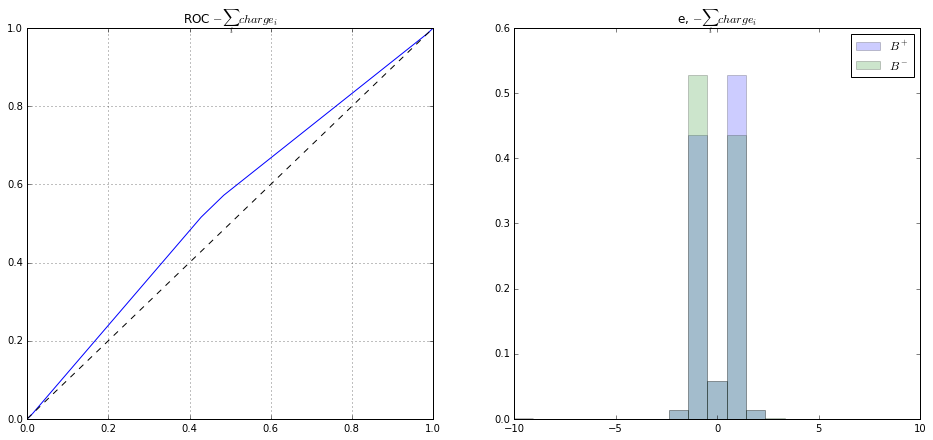

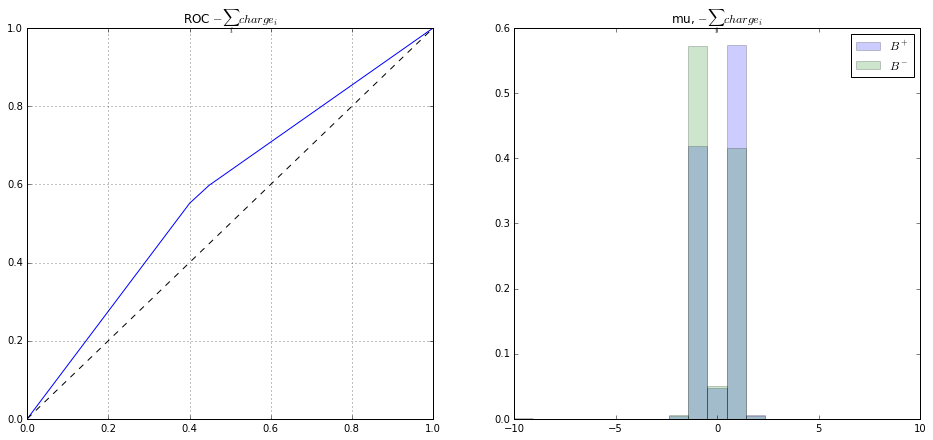

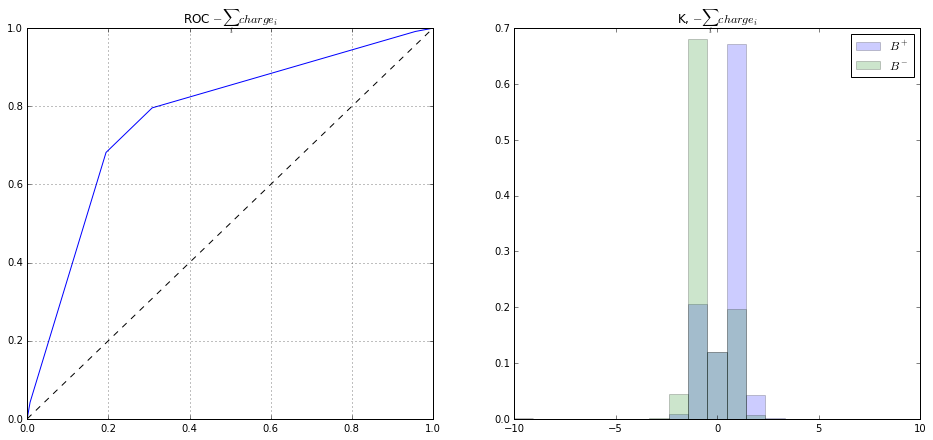

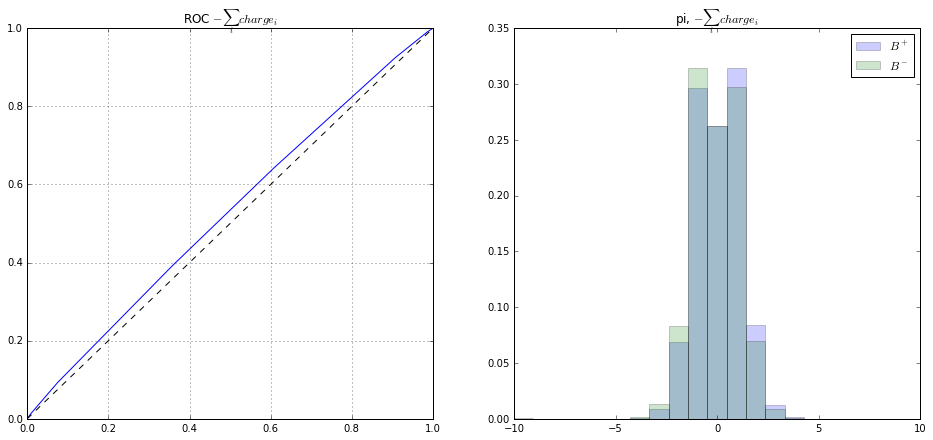

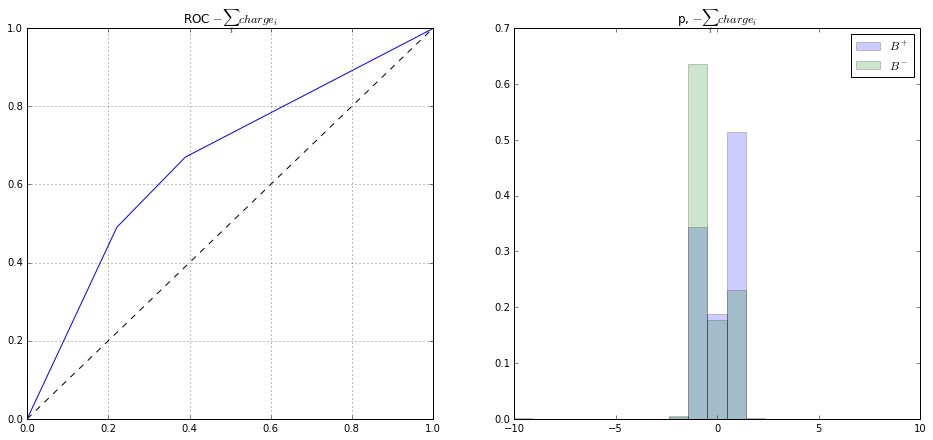

In [18]:
means_sum_of_charges_by_particle_os = [compute_sum_of_charges(data[mask & (data.OS_SS == -1)], 
                                                              name, bins=21, show_with_signal=False) 
                                       for mask, name in zip([e_mask, mu_mask, k_mask, pi_mask, p_mask], 
                                                             ['e', 'mu', 'K', 'pi', 'p'])]

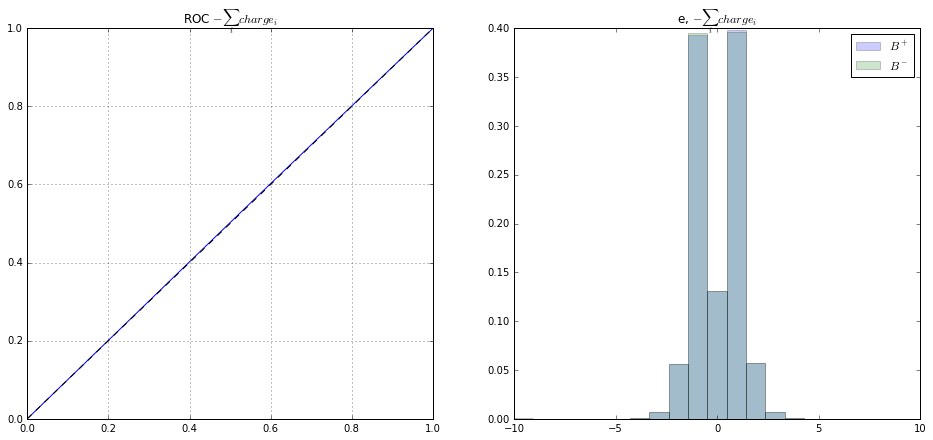

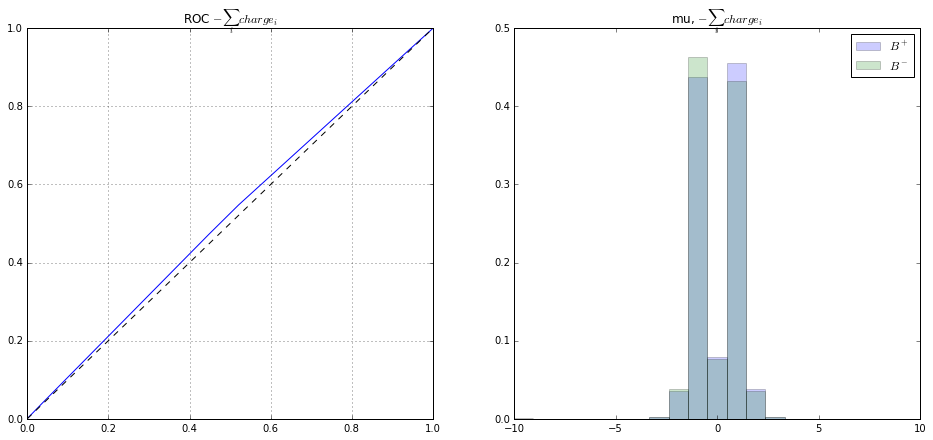

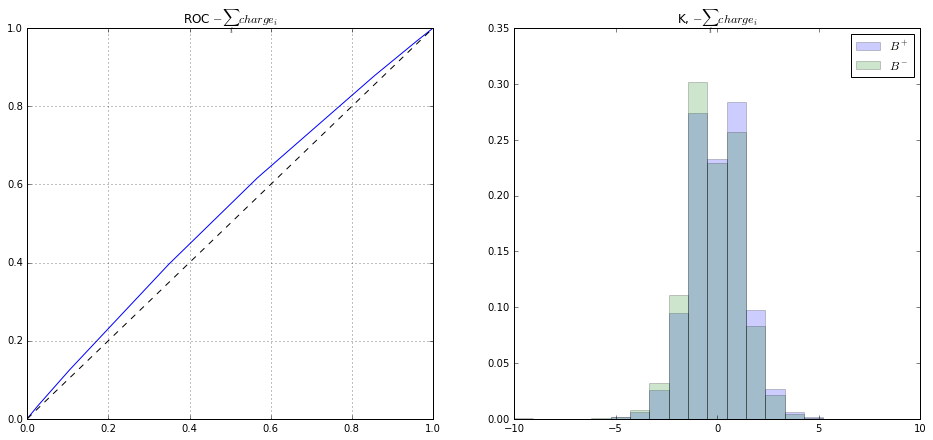

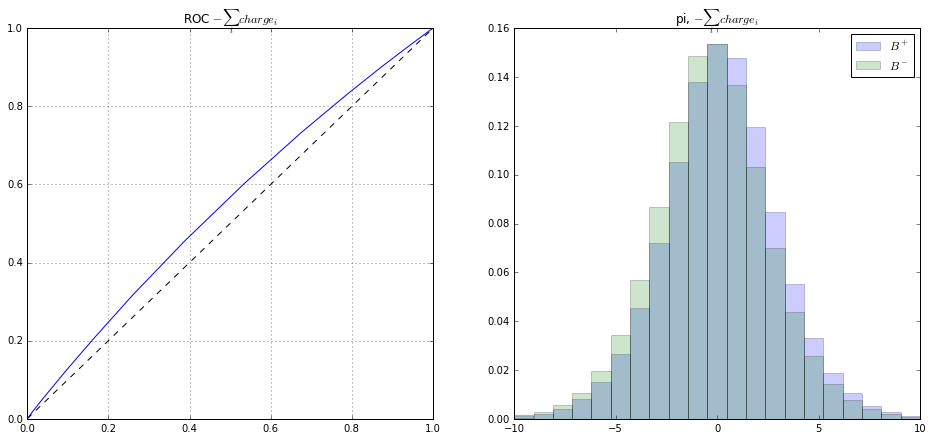

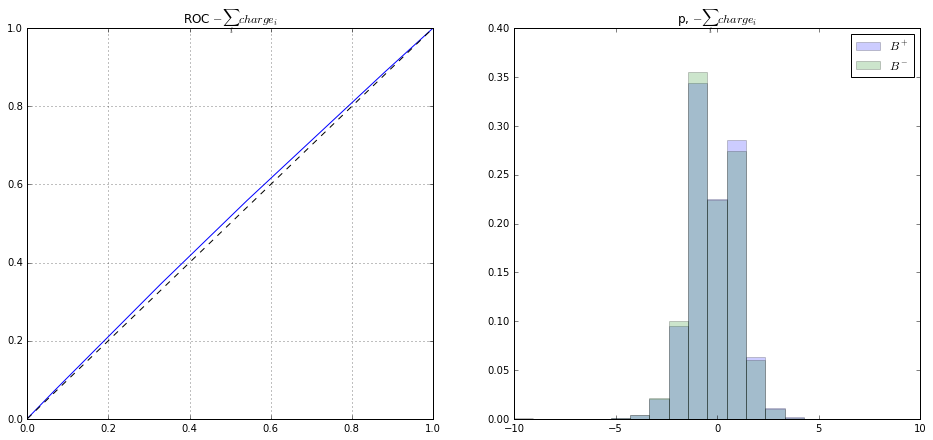

In [19]:
means_sum_of_charges_by_particle_ss = [compute_sum_of_charges(data[mask & (data.OS_SS != -1)], 
                                                              name, bins=21, show_with_signal=False) 
                                       for mask, name in zip([e_mask, mu_mask, k_mask, pi_mask, p_mask], 
                                                             ['e', 'mu', 'K', 'pi', 'p'])]

In [20]:
pandas.concat(means_sum_of_charges)

,$B^+$,$B^-$,ROC AUC,name
0,0.301028,-0.766497,0.585087,full
0,0.040453,-0.290346,0.541318,OS
0,0.149837,-0.181529,0.566993,SS


In [21]:
pandas.concat(means_sum_of_charges_by_particle)

,$B^+$,$B^-$,ROC AUC,name
0,0.029217,-0.020681,0.511974,e
0,0.069144,-0.077903,0.536140,mu
0,0.172858,-0.299909,0.591501,K
0,0.226336,-0.295750,0.549268,pi
0,-0.140544,-0.216291,0.516964,p


In [22]:
pandas.concat(means_sum_of_charges_by_particle_os)

,$B^+$,$B^-$,ROC AUC,name
0,0.088479,-0.087012,0.545231,e
0,0.151543,-0.152729,0.578819,mu
0,0.512594,-0.534809,0.774959,K
0,0.057672,-0.055855,0.525310,pi
0,0.157646,-0.393957,0.661428,p


In [23]:
pandas.concat(means_sum_of_charges_by_particle_ss)

,$B^+$,$B^-$,ROC AUC,name
0,0.007467,0.002491,0.501260,e
0,0.022943,-0.033860,0.513978,mu
0,0.016255,-0.142403,0.532115,K
0,0.195060,-0.265316,0.545556,pi
0,-0.151241,-0.199423,0.510874,p


#### Calculating tagging efficiency ($\epsilon_{tag}$)

$$\epsilon_{tag} = \frac{N (\text{passed selection})} {N (\text{all events})}$$

$$\Delta\epsilon_{tag} = \frac{\sqrt{N (\text{passed selection})}} {N (\text{all events})}$$

In [24]:
N_B_passed = float(get_events_number(data))
tagging_efficiency = N_B_passed / N_B_events
tagging_efficiency_delta = sqrt(N_B_passed) / N_B_events
tagging_efficiency, tagging_efficiency_delta

(0.99999597015496766, 0.00081953531474227297)

# Main idea: 
## find tracks, which can help reconstruct the sign of B if you know track sign.

`label` = `signB` * `signTrack`
* the highest output means that this is same sign B as track
* the lowest output means that this is opposite sign B than track

## Define features

In [25]:
features = ['cos_diff_phi', 'diff_pt', 'partPt', 'partP', 'nnkrec', 'diff_eta', 'EOverP', 
            'ptB', 'sum_PID_mu_k', 'proj', 'PIDNNe', 'sum_PID_k_e', 'PIDNNk', 'sum_PID_mu_e', 'PIDNNm',
            'phi', 'IP', 'IPerr', 'IPs', 'veloch', 'max_PID_k_e', 'ghostProb', 
            'IPPU', 'eta', 'max_PID_mu_e', 'max_PID_mu_k', 'partlcs']

## PID pairs scatters

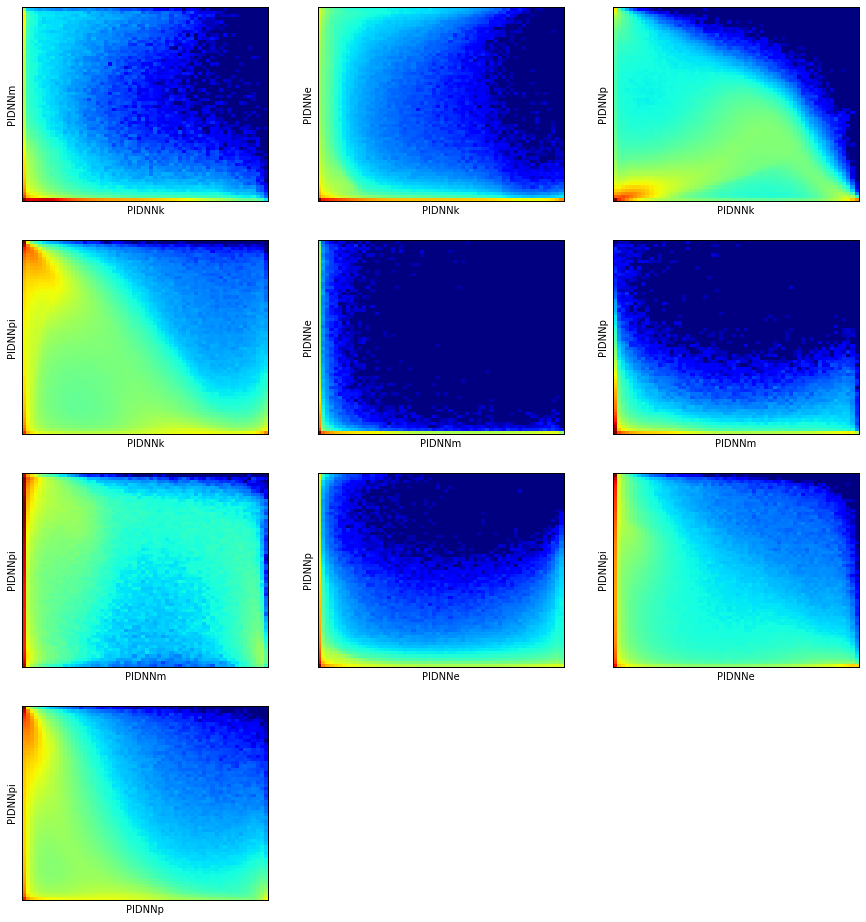

In [26]:
from itertools import combinations
figure(figsize=[15, 16])
bins = 60
step = 3
for i, (feature1, feature2) in enumerate(combinations(['PIDNNk', 'PIDNNm', 'PIDNNe', 'PIDNNp', 'PIDNNpi'], 2)):
    subplot(4, 3, i + 1)
    Z, (x, y) = numpy.histogramdd(data[[feature1, feature2]].values, bins=bins, range=([0, 1], [0, 1]))
    pcolor(numpy.log(Z).T, vmin=0)
    xlabel(feature1)
    ylabel(feature2)
    xticks(numpy.arange(bins, step), x[::step]), yticks(numpy.arange(bins, step), y[::step])

## count of tracks

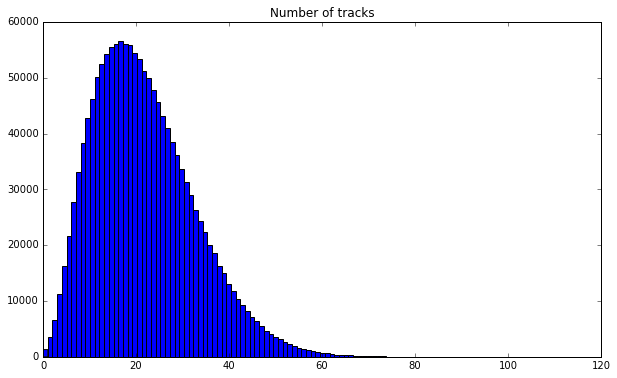

In [27]:
figure(figsize=(10, 6))

_, n_tracks_all = numpy.unique(data['event_id'], return_counts=True)
hist(n_tracks_all, bins=100, range=(0, 101))    
title('Number of tracks')

----

## Train to distinguish same sign vs opposite sign

In [28]:
from decisiontrain import DecisionTrainClassifier
from rep.estimators import SklearnClassifier
from hep_ml.losses import LogLossFunction

In [29]:
data_sw_passed_lds = LabeledDataStorage(data, data.label)

### small XGB for testing

In [ ]:
from rep.estimators import XGBoostClassifier
xgb = FoldingGroupClassifier(XGBoostClassifier(subsample=), n_folds=2, random_state=321, 
                             train_features=features, group_feature='group_column')
xgb.fit 

### DT

In [30]:
loss_function = LogLossFunction(regularization=100)
tt_base = DecisionTrainClassifier(learning_rate=0.1, n_estimators=4000, depth=6,
                                  max_features=15, n_threads=12, loss=loss_function)
tt_folding = FoldingGroupClassifier(SklearnClassifier(tt_base), n_folds=2, random_state=321, 
                                    train_features=features, group_feature='group_column')
%time tt_folding.fit_lds(data_sw_passed_lds)
pass

CPU times: user 3h 1min 26s, sys: 44min 13s, total: 3h 45min 39s
Wall time: 1h 54min 12s


In [31]:
import cPickle
with open('../models/dt_MC.pkl', 'w') as f:
    cPickle.dump(tt_folding, f)

In [32]:
comparison_report = tt_folding.test_on_lds(data_sw_passed_lds)

KFold prediction using folds column


In [33]:
comparison_report.compute_metric(RocAuc())

OrderedDict([('clf', 0.51693494266116635)])

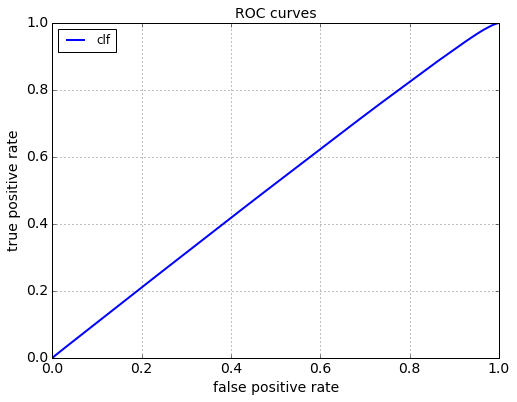

In [34]:
comparison_report.roc()

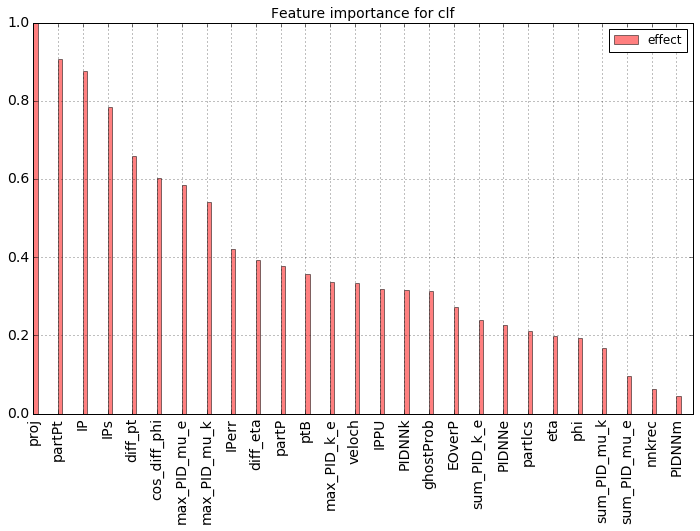

In [35]:
comparison_report.feature_importance()

KFold prediction using folds column


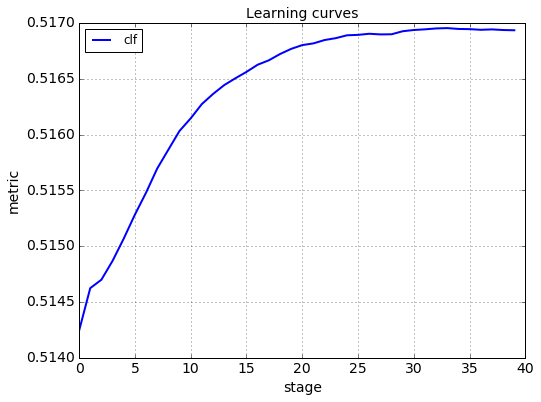

In [36]:
from rep.report.metrics import RocAuc
comparison_report.learning_curve(RocAuc(), steps=1)

---------

# Calibration

In [37]:
from utils import calibrate_probs, get_B_data_for_given_part
from utils import plot_calibration

### track calibration

In [38]:
p_track_calibrated, calibrator_tracks = calibrate_probs(data.label.values, data.N_sig_sw.values, 
                                                        tt_folding.predict_proba(data)[:, 1],
                                                        logistic=True)

KFold prediction using folds column


In [39]:
roc_auc_score(data.label, p_track_calibrated)

0.51693468972963241

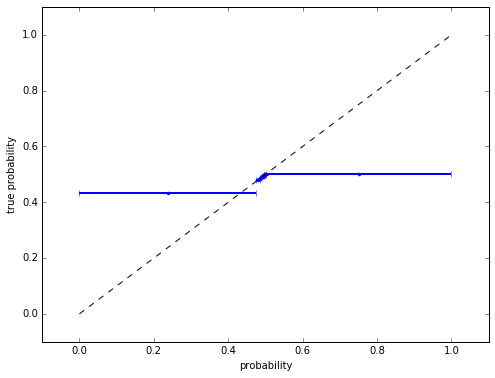

In [40]:
plot_calibration(p_track_calibrated, data.label.values)

### p(B) calibration

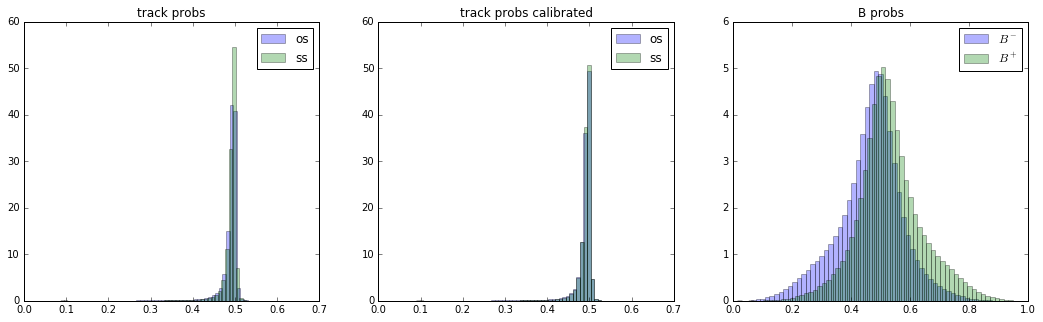

AUC for tagged: 0.661654092848 AUC with untag: 0.661653705538


In [42]:
Bsign, Bweight, Bprob, Bevent, auc_full = get_B_data_for_given_part(p_track_calibrated, data, 
                                                                    N_B_events, logistic=True)

In [43]:
Bprob_calibrated, calibrator_B = calibrate_probs(Bsign, Bweight, Bprob, symmetrize=True)

In [68]:
Bprob_calibrated_log, calibrator_B_log = calibrate_probs(Bsign, Bweight, Bprob, symmetrize=True, logistic=True)

### mistag calibration check

In [45]:
from utils import compute_mistag
bins = [0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]
percentile_bins = [10, 20, 30, 40, 50, 60, 70, 80, 90]

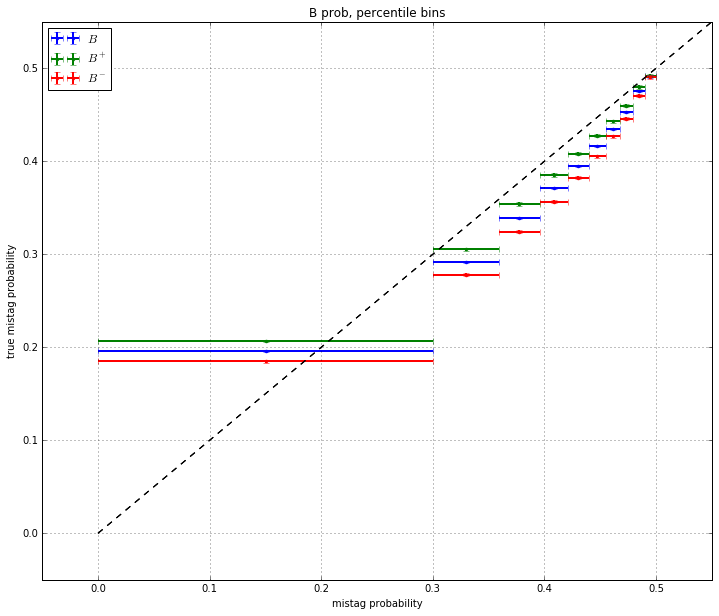

In [46]:
figsize(12, 10)
compute_mistag(Bprob, Bsign, Bweight, Bsign > -100, label="$B$", uniform=False,
               bins=percentile_bins)
compute_mistag(Bprob, Bsign, Bweight, Bsign == 1, label="$B^+$", uniform=False, 
               bins=percentile_bins)
compute_mistag(Bprob, Bsign, Bweight, Bsign == -1, label="$B^-$", uniform=False, 
               bins=percentile_bins)
legend(loc='best'),  xlabel('mistag probability'), ylabel('true mistag probability')
title('B prob, percentile bins')

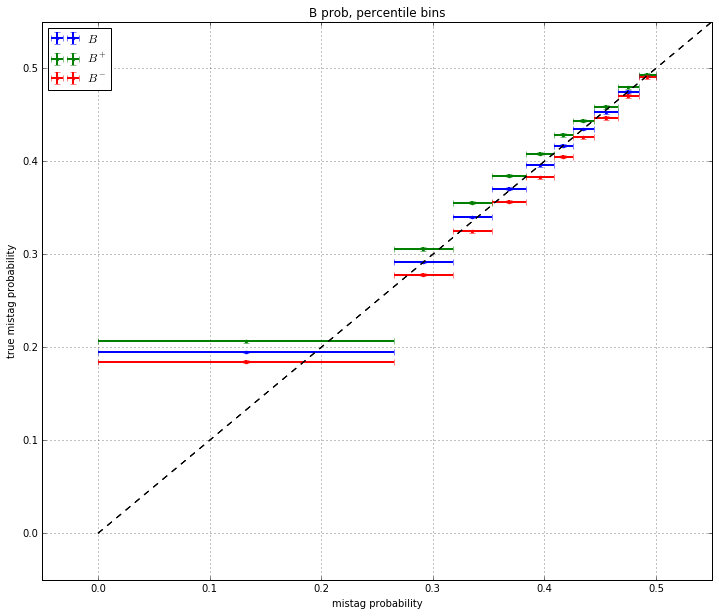

In [47]:
figsize(12, 10)
compute_mistag(Bprob_calibrated, Bsign, Bweight, Bsign > -100, label="$B$", uniform=False,
               bins=percentile_bins)
compute_mistag(Bprob_calibrated, Bsign, Bweight, Bsign == 1, label="$B^+$", uniform=False, 
               bins=percentile_bins)
compute_mistag(Bprob_calibrated, Bsign, Bweight, Bsign == -1, label="$B^-$", uniform=False, 
               bins=percentile_bins)
legend(loc='best'),  xlabel('mistag probability'), ylabel('true mistag probability')
title('B prob, percentile bins')

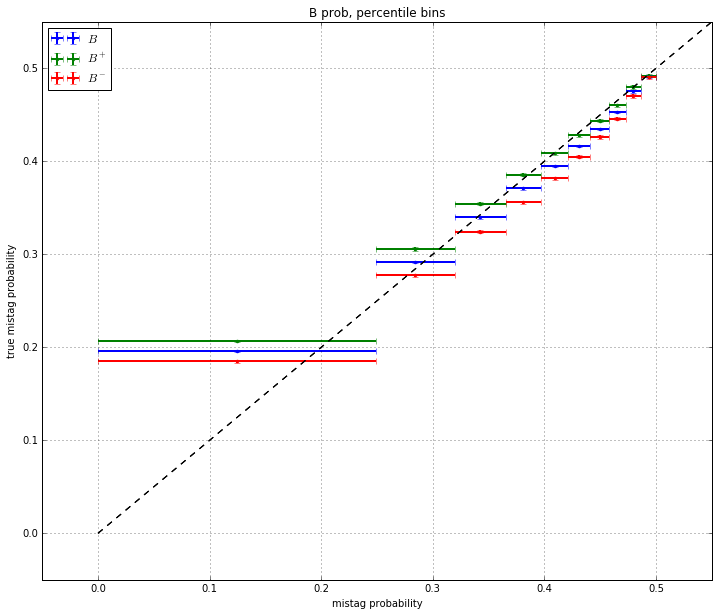

In [48]:
figsize(12, 10)
compute_mistag(Bprob_calibrated_log, Bsign, Bweight, Bsign > -100, label="$B$", uniform=False,
               bins=percentile_bins)
compute_mistag(Bprob_calibrated_log, Bsign, Bweight, Bsign == 1, label="$B^+$", uniform=False, 
               bins=percentile_bins)
compute_mistag(Bprob_calibrated_log, Bsign, Bweight, Bsign == -1, label="$B^-$", uniform=False, 
               bins=percentile_bins)
legend(loc='best'),  xlabel('mistag probability'), ylabel('true mistag probability')
title('B prob, percentile bins')

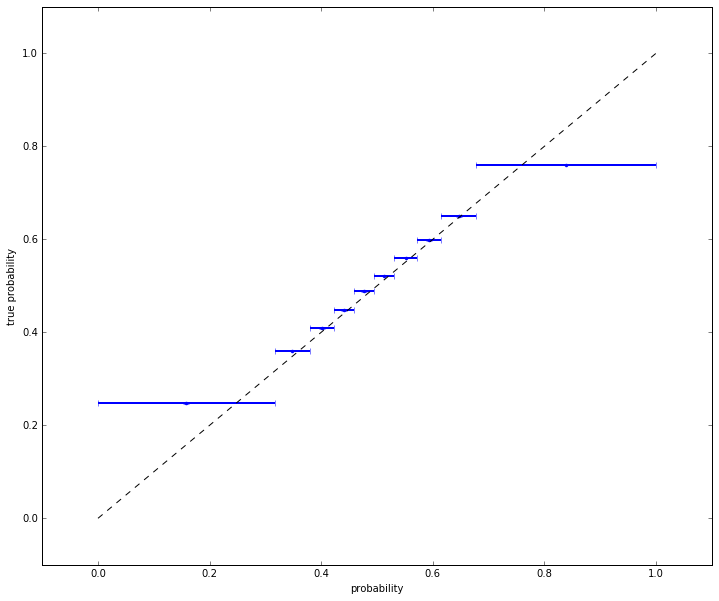

In [49]:
plot_calibration(Bprob_calibrated, Bsign > 0)

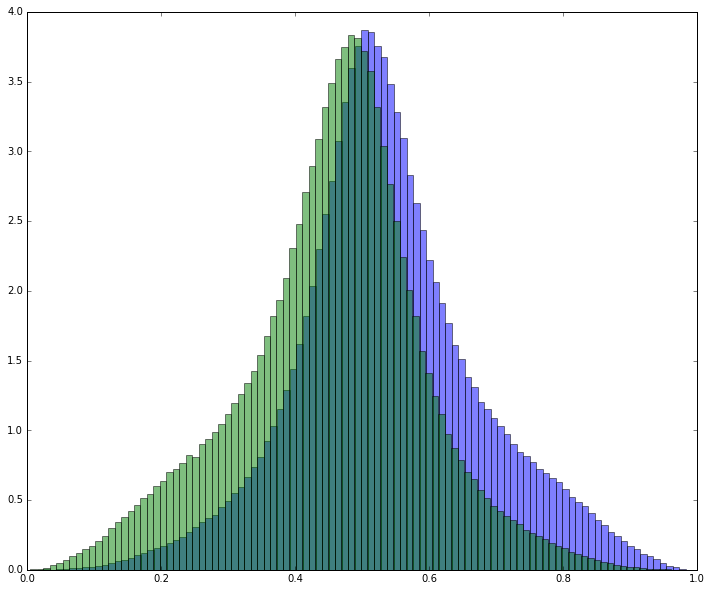

In [63]:
hist(Bprob_calibrated_log[Bsign == 1], normed=True, alpha=0.5, bins=100)
hist(Bprob_calibrated_log[Bsign == -1], normed=True, alpha=0.5, bins=100);

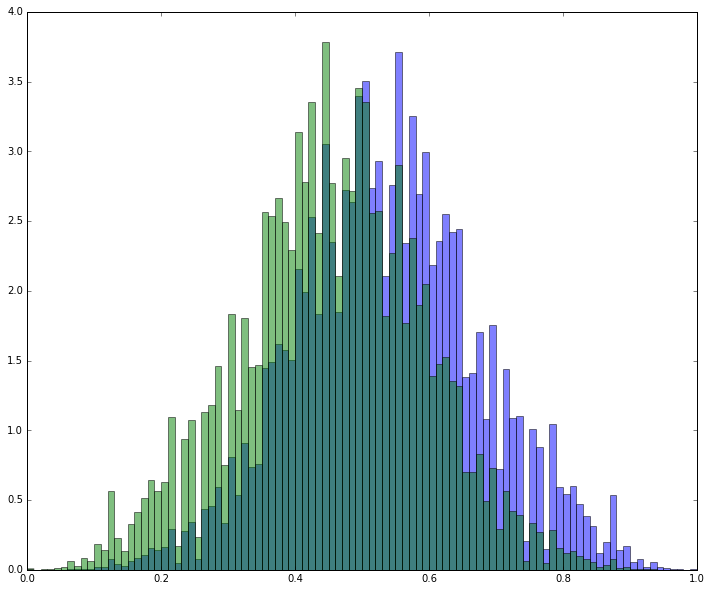

In [64]:
hist(Bprob_calibrated[Bsign == 1], normed=True, alpha=0.5, bins=100, range=(0, 1))
hist(Bprob_calibrated[Bsign == -1], normed=True, alpha=0.5, bins=100, range=(0, 1));

In [50]:
with open('../models/calibrator_tracks_MC.pkl', 'w') as f:
    cPickle.dump(calibrator_tracks, f)
with open('../models/calibrator_B_MC.pkl', 'w') as f:
    cPickle.dump(calibrator_B, f)

In [69]:
with open('../models/calibrator_B_MC_log.pkl', 'w') as f:
    cPickle.dump(calibrator_B_log, f)

--------------------------

## Save model for combination with vertex 

In [53]:
from utils import prepare_B_data_for_given_part

KFold prediction using folds column


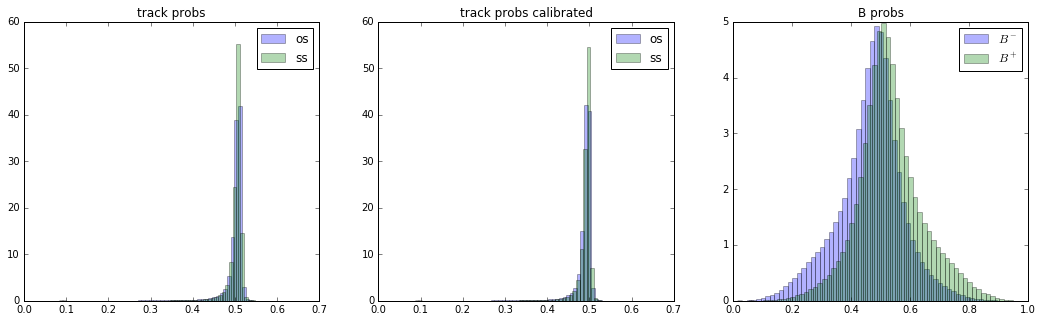

AUC for tagged: 0.661580935325 AUC with untag: 0.661580547942


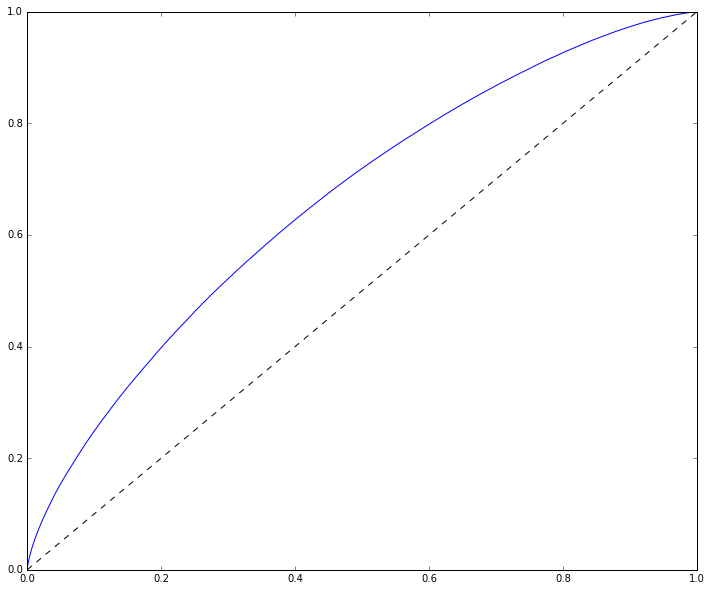

In [54]:
Bdata_prepared = prepare_B_data_for_given_part(tt_folding, [data], logistic=True, N_B_events=N_B_events)
Bdata_prepared.to_csv('../models/Bdata_tracks_MC.csv', header=True, index=False)

In [55]:
from utils import predict_by_estimator
part_data, part_prob = predict_by_estimator(tt_folding, [data])
pandas.DataFrame({'label': part_data.label.values,
                  'weight': part_data.N_sig_sw, 
                  'part_prob': part_prob,
                  'OS_SS': part_data.OS_SS,
                  'xFlag': part_data.xFlag}).to_csv('../models/part_tracks_MC.csv', header=True, index=False)

KFold prediction using folds column


# Bootstrap effective efficiency estimation

KFold prediction using folds column


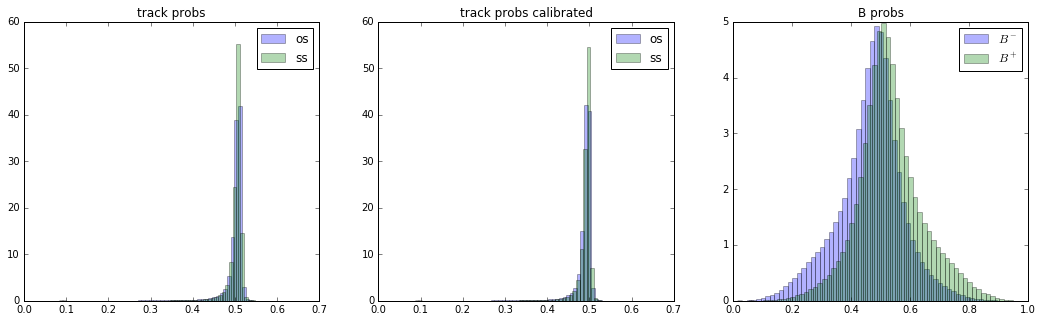

AUC for tagged: 0.661580935325 AUC with untag: 0.661580547942


In [ ]:
from utils import get_result_with_bootstrap_for_given_part
result = get_result_with_bootstrap_for_given_part(tagging_efficiency, tagging_efficiency_delta, tt_folding, 
                                                  [data], 'tt-log', logistic=True, N_B_events=N_B_events, 
                                                  n_calibrations=30)
result.to_csv('../img/tracks_MC.csv', index=False, header=True)

In [57]:
result

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,tt-log,99.999597,0.081954,0.082584,0.000009,8.258385,0.006827,66.158055,0
